In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from matplotlib_inline.backend_inline import set_matplotlib_formats
import seaborn as sns
from boosting import GradientBoostingMSE
from random_forest import RandomForestMSE
from utils import ConvergenceHistory

set_matplotlib_formats('pdf', 'svg')
warnings.filterwarnings("ignore")

%matplotlib inline

%config InlineBackend.figure_format = 'svg'

In [4]:
! unzip kc_house_data.csv.zip

Archive:  kc_house_data.csv.zip
  inflating: kc_house_data.csv       


In [48]:
dt = pd.read_csv('kc_house_data.csv')
dt.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [49]:
dt.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [50]:
for column in dt.columns:
  print(column, dt[column].value_counts)

id <bound method IndexOpsMixin.value_counts of 0        7129300520
1        6414100192
2        5631500400
3        2487200875
4        1954400510
            ...    
21608     263000018
21609    6600060120
21610    1523300141
21611     291310100
21612    1523300157
Name: id, Length: 21613, dtype: int64>
date <bound method IndexOpsMixin.value_counts of 0        20141013T000000
1        20141209T000000
2        20150225T000000
3        20141209T000000
4        20150218T000000
              ...       
21608    20140521T000000
21609    20150223T000000
21610    20140623T000000
21611    20150116T000000
21612    20141015T000000
Name: date, Length: 21613, dtype: object>
price <bound method IndexOpsMixin.value_counts of 0        221900.0
1        538000.0
2        180000.0
3        604000.0
4        510000.0
           ...   
21608    360000.0
21609    400000.0
21610    402101.0
21611    400000.0
21612    325000.0
Name: price, Length: 21613, dtype: float64>
bedrooms <bound method IndexOpsMixin

In [51]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [52]:
import folium

In [53]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.

    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [54]:
show_circles_on_map(dt.sample(2000), 'lat', 'long', 'blue')

In [55]:
dt['date'] = pd.to_datetime(dt['date'], format="%Y%m%dT%H%M%S")
dt['year'] = dt['date'].dt.year
dt['month'] = dt['date'].dt.month
dt['day'] = dt['date'].dt.day
dt = dt.drop(columns=['date'])

In [56]:
dt = dt.drop(columns=['id'])

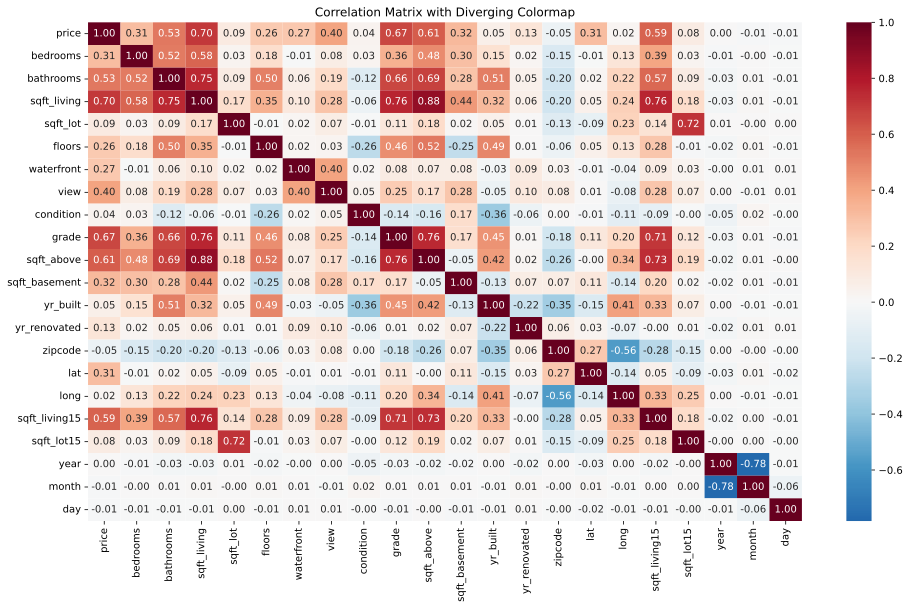

In [57]:
correlations = dt.corr()
plt.figure(figsize=(16, 9))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='RdBu_r', cbar=True, center=0)
plt.title("Correlation Matrix with Diverging Colormap")
plt.savefig('conf_matrix.pdf', format='pdf')
plt.show()

In [60]:
dt_var = dt.drop(columns=['price']).var()
for index, item in zip(dt_var.index, dt_var.values):
    print(f"Дисперсия признака {index} равна {item}")

Дисперсия признака bedrooms равна 0.8650150097573724
Дисперсия признака bathrooms равна 0.5931512887355798
Дисперсия признака sqft_living равна 843533.6813681519
Дисперсия признака sqft_lot равна 1715658774.1754544
Дисперсия признака floors равна 0.29158800687709074
Дисперсия признака waterfront равна 0.007485225502689098
Дисперсия признака view равна 0.5872426169774596
Дисперсия признака condition равна 0.42346651239404876
Дисперсия признака grade равна 1.3817032893476293
Дисперсия признака sqft_above равна 685734.6672685045
Дисперсия признака sqft_basement равна 195872.66840094145
Дисперсия признака yr_built равна 862.7972621659763
Дисперсия признака yr_renovated равна 161346.2118623043
Дисперсия признака zipcode равна 2862.7878348129493
Дисперсия признака lat равна 0.01919990179600803
Дисперсия признака long равна 0.019832622017890593
Дисперсия признака sqft_living15 равна 469761.23994532257
Дисперсия признака sqft_lot15 равна 745518225.3404043
Дисперсия признака year равна 0.218664

In [16]:
dt.columns[dt.isna().any()]

Index([], dtype='object')

In [17]:
X = dt.drop(columns=['price']).to_numpy()
y = dt['price'].to_numpy()

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [19]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

## RandomForestMSE

In [61]:
model = RandomForestMSE(n_estimators=250,
                        tree_params={'max_features': 5, 'max_depth': 10})
history = model.fit(X_train, y_train, X_test, y_test)

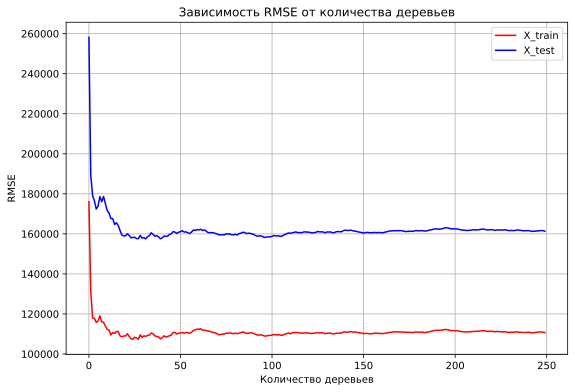

In [62]:
fig = plt.figure(figsize=(9, 6))

plt.title('Зависимость RMSE от количества деревьев')

plt.grid(True, zorder=0)
plt.xlabel("Количество деревьев")
plt.ylabel("RMSE")

plt.plot(np.array(history['train']) ** 0.5, color='red', label='X_train')
plt.plot(np.array(history['val']) ** 0.5, color='blue', label='X_test')
plt.legend()
plt.savefig('rmse_n_trees_rf.pdf', format='pdf')
plt.show()


In [22]:
best_number_of_estimators = np.argmin(np.array(history['val']))
best_number_of_estimators

171

In [23]:
max_features = [1, 2, 3, 4, 5, 7, 9, 10, 12, 15, 17, 19, 21]

rmse_data = {}
timings = {}

for max_feature in max_features:
    model = RandomForestMSE(n_estimators=best_number_of_estimators,
                        tree_params={'max_features': max_feature, 'max_depth': 10})
    start_time = time.time()
    history = model.fit(X_train, y_train)
    rmse_data[max_feature] = rmse(y_test, model.predict(X_test))
    timings[max_feature] = time.time() - start_time

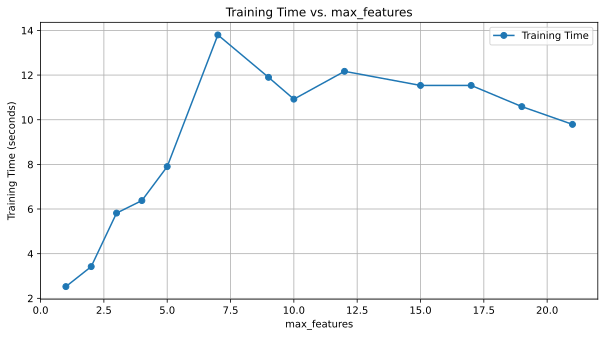

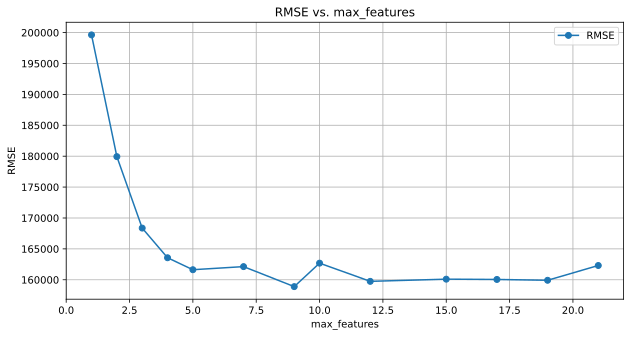

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(max_features, [timings[mf] for mf in max_features], marker='o', label="Training Time")
plt.title("Training Time vs. max_features")
plt.xlabel("max_features")
plt.ylabel("Training Time (seconds)")
plt.grid(True)
plt.legend()
plt.savefig('time_features_rf.pdf', format='pdf')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(max_features, [rmse_data[mf] for mf in max_features], marker='o', label="RMSE")
plt.title("RMSE vs. max_features")
plt.xlabel("max_features")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.savefig('rmse_features_rf.pdf', format='pdf')
plt.show()

In [25]:
best_max_features = min(rmse_data, key=rmse_data.get)
print(best_max_features)

9


In [29]:
max_depths = [2, 4, 6, 8, 10, 15, 20, 25, 30, 40, 50, 80, None]

rmse_data = {}
timings = {}

for max_depth in max_depths:
    model = RandomForestMSE(n_estimators=best_number_of_estimators,
                        tree_params={'max_features': best_max_features, 'max_depth': max_depth})
    start_time = time.time()
    history = model.fit(X_train, y_train)
    rmse_data[max_depth] = rmse(y_test, model.predict(X_test))
    timings[max_depth] = time.time() - start_time

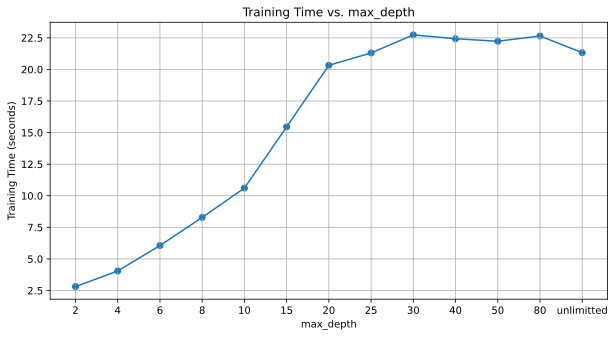

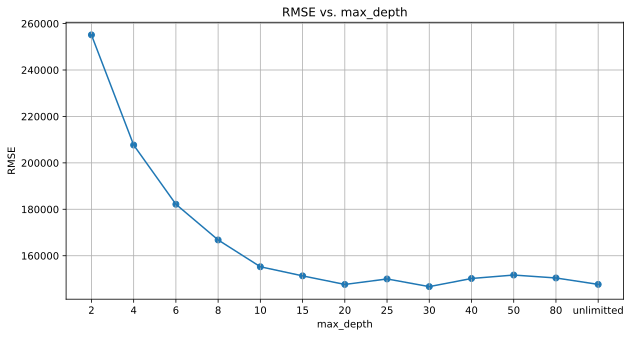

In [30]:
plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(max_depths)), timings.values())
plt.plot(np.arange(len(max_depths)), timings.values())
plt.xticks(ticks=np.arange(len(max_depths)), labels=[2, 4, 6, 8, 10, 15, 20, 25, 30, 40, 50, 80, 'unlimitted'])
plt.title("Training Time vs. max_depth")
plt.xlabel("max_depth")
plt.ylabel("Training Time (seconds)")
plt.grid(True)
plt.savefig('time_depth_rf.pdf', format='pdf')
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(max_depths)), rmse_data.values())
plt.plot(np.arange(len(max_depths)), rmse_data.values())
plt.xticks(ticks=np.arange(len(max_depths)), labels=[2, 4, 6, 8, 10, 15, 20, 25, 30, 40, 50, 80, 'unlimitted'])
plt.title("RMSE vs. max_depth")
plt.xlabel("max_depth")
plt.ylabel("RMSE")
plt.grid(True)
plt.savefig('rmse_depth_rf.pdf', format='pdf')
plt.show()

In [31]:
best_max_depth = min(rmse_data, key=rmse_data.get)
print(best_max_depth)

30


### Лучший RandomForestMSE

In [32]:
model = RandomForestMSE(n_estimators=best_number_of_estimators,
                        tree_params={'max_features': best_max_features, 'max_depth': best_max_depth})
start_time = time.time()
history = model.fit(X_train, y_train)
print('Leraning time: ', time.time() - start_time)
print('RMSE: ', rmse(y_test, model.predict(X_test)))

Leraning time:  21.98995065689087
RMSE:  147736.15936707004


## Бустинг

In [64]:
model = GradientBoostingMSE(n_estimators=250,
                        tree_params={'max_features': 5, 'max_depth': 10})
history = model.fit(X_train, y_train, X_test, y_test)

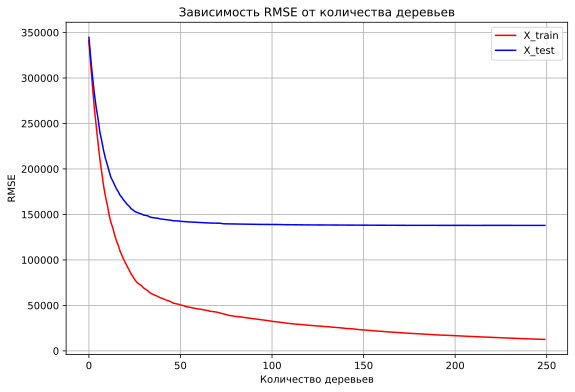

In [65]:
fig = plt.figure(figsize=(9, 6))

plt.title('Зависимость RMSE от количества деревьев')

plt.grid(True, zorder=0)
plt.xlabel("Количество деревьев")
plt.ylabel("RMSE")

plt.plot(np.array(history['train']) ** 0.5, color='red', label='X_train')
plt.plot(np.array(history['val']) ** 0.5, color='blue', label='X_test')
plt.legend()
plt.savefig('rmse_n_trees_b.pdf', format='pdf')
plt.show()

In [35]:
best_number_of_estimators = np.argmin(np.array(history['val']))
best_number_of_estimators

211

In [36]:
max_features = [1, 2, 3, 4, 5, 7, 9, 10, 12, 15, 17, 19, 21]

rmse_data = {}
timings = {}

for max_feature in max_features:
    model = GradientBoostingMSE(n_estimators=best_number_of_estimators,
                        tree_params={'max_features': max_feature, 'max_depth': 10})
    start_time = time.time()
    history = model.fit(X_train, y_train)
    rmse_data[max_feature] = rmse(y_test, model.predict(X_test))
    timings[max_feature] = time.time() - start_time

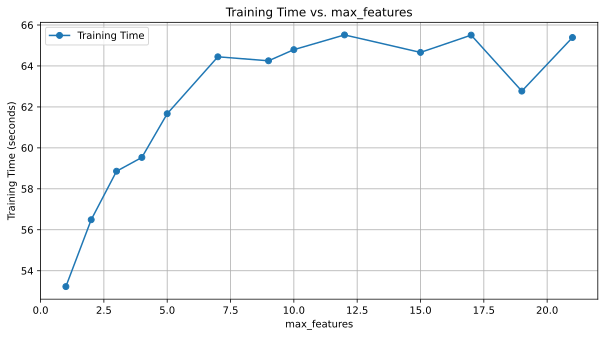

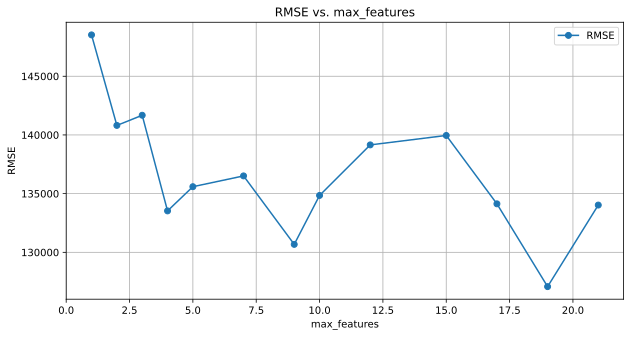

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(max_features, [timings[mf] for mf in max_features], marker='o', label="Training Time")
plt.title("Training Time vs. max_features")
plt.xlabel("max_features")
plt.ylabel("Training Time (seconds)")
plt.grid(True)
plt.legend()
plt.savefig('time_features_b.pdf', format='pdf')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(max_features, [rmse_data[mf] for mf in max_features], marker='o', label="RMSE")
plt.title("RMSE vs. max_features")
plt.xlabel("max_features")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.savefig('rmse_features_b.pdf', format='pdf')
plt.show()

In [38]:
best_max_features = min(rmse_data, key=rmse_data.get)
print(best_max_features)

19


In [39]:
max_depths = [2, 4, 6, 8, 10, 15, 20, 25, 30, 40, 50, 80, None]

rmse_data = {}
timings = {}

for max_depth in max_depths:
    model = GradientBoostingMSE(n_estimators=best_number_of_estimators,
                        tree_params={'max_features': best_max_features, 'max_depth': max_depth})
    start_time = time.time()
    history = model.fit(X_train, y_train)
    rmse_data[max_depth] = rmse(y_test, model.predict(X_test))
    timings[max_depth] = time.time() - start_time

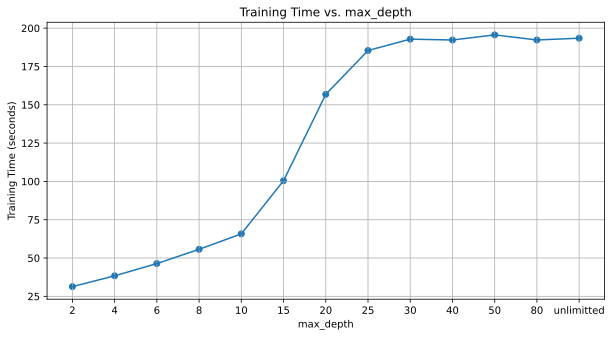

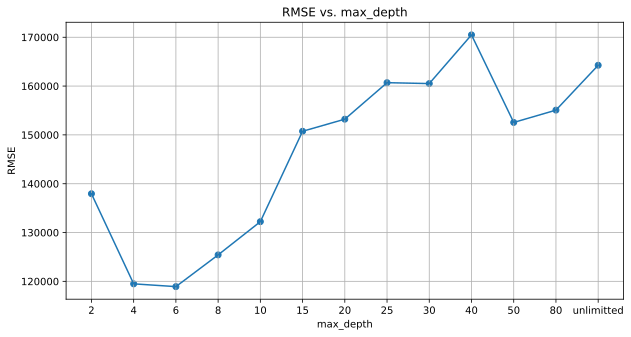

In [40]:
plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(max_depths)), timings.values())
plt.plot(np.arange(len(max_depths)), timings.values())
plt.xticks(ticks=np.arange(len(max_depths)), labels=[2, 4, 6, 8, 10, 15, 20, 25, 30, 40, 50, 80, 'unlimitted'])
plt.title("Training Time vs. max_depth")
plt.xlabel("max_depth")
plt.ylabel("Training Time (seconds)")
plt.grid(True)
plt.savefig('time_depth_b.pdf', format='pdf')
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(max_depths)), rmse_data.values())
plt.plot(np.arange(len(max_depths)), rmse_data.values())
plt.xticks(ticks=np.arange(len(max_depths)), labels=[2, 4, 6, 8, 10, 15, 20, 25, 30, 40, 50, 80, 'unlimitted'])
plt.title("RMSE vs. max_depth")
plt.xlabel("max_depth")
plt.ylabel("RMSE")
plt.grid(True)
plt.savefig('rmse_depth_b.pdf', format='pdf')
plt.show()

In [41]:
best_max_depth = min(rmse_data, key=rmse_data.get)
print(best_max_depth)

6


In [42]:
learning_rates = np.linspace(0.01, 1, 20)

rmse_data = {}
timings = {}

for learning_rate in learning_rates:
    model = GradientBoostingMSE(n_estimators=best_number_of_estimators,
                        tree_params={'max_features': best_max_features, 'max_depth': best_max_depth},
                        learning_rate=learning_rate)
    start_time = time.time()
    history = model.fit(X_train, y_train)
    rmse_data[learning_rate] = rmse(y_test, model.predict(X_test))
    timings[learning_rate] = time.time() - start_time

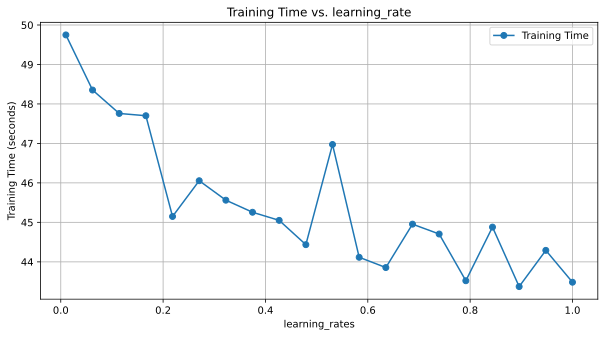

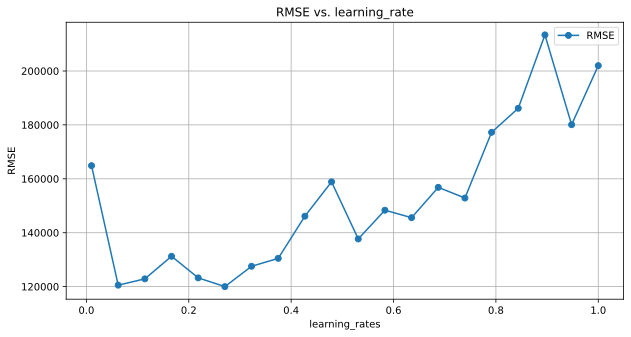

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(learning_rates, timings.values(), marker='o', label="Training Time")
plt.title("Training Time vs. learning_rate")
plt.xlabel("learning_rates")
plt.ylabel("Training Time (seconds)")
plt.grid(True)
plt.legend()
plt.savefig('time_lrates_b.pdf', format='pdf')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(learning_rates, rmse_data.values(), marker='o', label="RMSE")
plt.title("RMSE vs. learning_rate")
plt.xlabel("learning_rates")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.savefig('rmse_lrates_b.pdf', format='pdf')
plt.show()

In [45]:
best_learning_rate = min(rmse_data, key=rmse_data.get)
print(best_learning_rate)

0.2705263157894737


### Лучший бустинг

In [46]:
model = GradientBoostingMSE(n_estimators=best_number_of_estimators,
                        tree_params={'max_features': best_max_features, 'max_depth': best_max_depth},
                        learning_rate=best_learning_rate)
start_time = time.time()
history = model.fit(X_train, y_train)
print('Leraning time: ', time.time() - start_time)
print('RMSE: ', rmse(y_test, model.predict(X_test)))

Leraning time:  46.27242064476013
RMSE:  123530.98922074263
